<a href="https://colab.research.google.com/github/MLEndDatasets/Notebooks/blob/main/MLEnd_Spoken_Numerals_Starter_kit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob,time,os

import librosa
import IPython.display as ipd

from sklearn import svm
from sklearn import metrics
import seaborn as sns

try:
    import mlend
except:
    !pip install mlend
    import mlend

import spkit as sp
from spkit.ml import ClassificationTree, NaiveBayes

from mlend import download_spoken_numerals, spoken_numerals_load

mlend.__version__

'1.0.0.2'

# Download Data (subset)

In [3]:
subset = {'Numeral':[0,1,2,3],'Intonation':['bored']}
datadir = download_spoken_numerals(save_to = '../MLEnd', subset = subset,verbose=1,overwrite=False)

100%|▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓|996\996|46876.wav
Done!


In [4]:
datadir

'../MLEnd/spoken_numerals'

# Read Data



In [5]:
TrainSet, TestSet, MAPs = spoken_numerals_load(datadir_main = datadir, train_test_split = 'Benchmark_B',
                              verbose=1,encode_labels=True)

Total 996 found in ../MLEnd/spoken_numerals/MLEndSND_audiofiles/


# Listen to some exampls

In [7]:
List_of_files = TrainSet['X_paths']

In [9]:
for k in range(5):
    fpath = List_of_files[k]
    x, fs = librosa.load(fpath,sr=None)
    print(k,fs, x.shape)
    display(ipd.Audio(x,rate=fs))

0 22050 (21504,)


1 22050 (28672,)


2 22050 (30464,)


3 22050 (35840,)


4 22050 (46848,)


# Feature Extraction

In [10]:
def get_pitch(x,fs,winlen=0.02):
    #winLen = 0.02
    p = winlen*fs
    frame_length = int(2**int(p-1).bit_length())
    hop_length = frame_length//2
    f0, voiced_flag, voiced_probs = librosa.pyin(y=x, fmin=80, fmax=450, sr=fs,
                                                 frame_length=frame_length,hop_length=hop_length)
    return f0,voiced_flag

def extract_features_audio(wav_files,scale_audio=False,features='pitch'):
    '''
    Extract features X
    ============

    input
    ------
    wav_files: list of path of all the wav files

    features: 'pitch', or 'raw'
            : if pitch, 4 features are extracted from audio file : (power, pitch_mean, pitch_sd, voiced_len)
            : if raw, raw audio file is returned, without any preprocessing


    output
    ------

    X: Features (n,4) or raw audio file (n,~)
    '''

    X,y_label =[],[]
    #for kk,file in tqdm(wav_files_selected):
    for kk,file in enumerate(wav_files):

        sp.utils.ProgBar_JL(kk,len(wav_files), color='green')
        # Read wav file
        fs = None # if None, fs would be 22050
        x, fs = librosa.load(file,sr=fs)

        # Scale it
        if scale_audio: x = x/np.max(np.abs(x))

        if features=='pitch':
            # Pitch and voice region
            f0, voiced_flag = get_pitch(x,fs,winlen=0.02)
            pitch_mean = np.nanmean(f0) if np.mean(np.isnan(f0))<1 else 0     #average pitch
            pitch_std  = np.nanstd(f0) if np.mean(np.isnan(f0))<1 else 0      #variation in pitch (sd)

            winlen=0.02
            p = winlen*fs
            frame_length = int(2**int(p-1).bit_length())
            hop_length = frame_length//2

            voiced_len = np.sum(voiced_flag)*hop_length/fs                    #length of voiced segment

            # Power
            #energy = np.sum(x**2)/fs
            power = np.sum(x**2)/len(x)

            xi = [power,pitch_mean,pitch_std,voiced_len]

            feanture_names=['power', 'pitch_mean', 'pitch_sd', 'voiced_len']
        else:
            #features=='raw'
            xi = x.copy()
            feanture_names=['raw audio']

        X.append(xi)

    X = np.array(X)
    return X, feanture_names

In [11]:
X_train_paths = TrainSet['X_paths']
Y_train = TrainSet['Y_encoded'][:,0]

X_test_paths = TestSet['X_paths']
Y_test = TestSet['Y_encoded'][:,0]

In [12]:
X_train_f,feature_names = extract_features_audio(X_train_paths,scale_audio=True,features='pitch')
X_test_f,feature_names  = extract_features_audio(X_test_paths,scale_audio=True,features='pitch')
X_train_f.shape, X_test_f.shape

100%|▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓|718\718|
Done!
100%|▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓|278\278|
Done!


((718, 4), (278, 4))

In [14]:
print(X_train_f.shape, Y_train.shape, X_test_f.shape, Y_test.shape)

(718, 4) (718,) (278, 4) (278,)


In [15]:
feature_names

['power', 'pitch_mean', 'pitch_sd', 'voiced_len']

# Decision Tree

In [24]:
model = ClassificationTree(max_depth=4)
model.fit(X_train_f, Y_train,feature_names=feature_names,verbose=1)

Number of features:: 4
Number of samples :: 718
---------------------------------------
|Building the tree.....................
|
|.........................tree is buit!
---------------------------------------


In [25]:
yp_train = model.predict(X_train_f)
yp_test = model.predict(X_test_f)


trAc = np.mean(yp_train==Y_train)
tsAc = np.mean(yp_test==Y_test)


print('Training Accuracy', trAc)
print('Testing  Accuracy', tsAc)

Training Accuracy 0.42618384401114207
Testing  Accuracy 0.3345323741007194


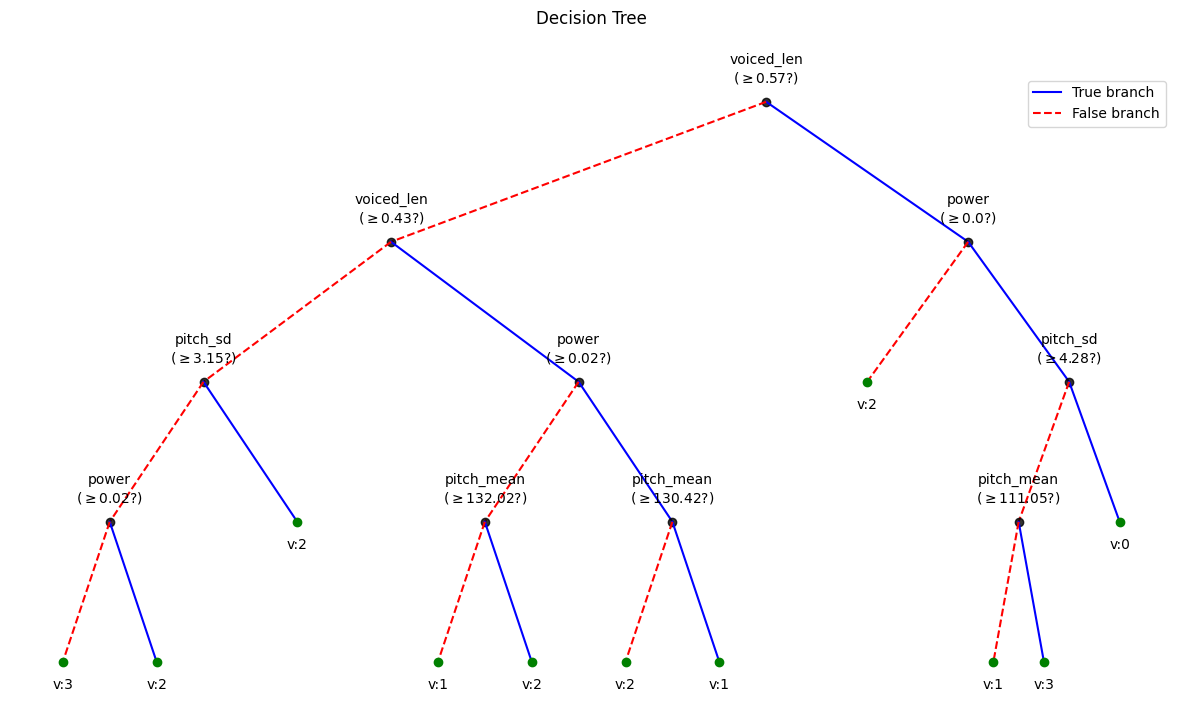

In [26]:
plt.figure(figsize=(15,8))
model.plotTree()

In [27]:
Class_name = ['0', '1', '2', '3']

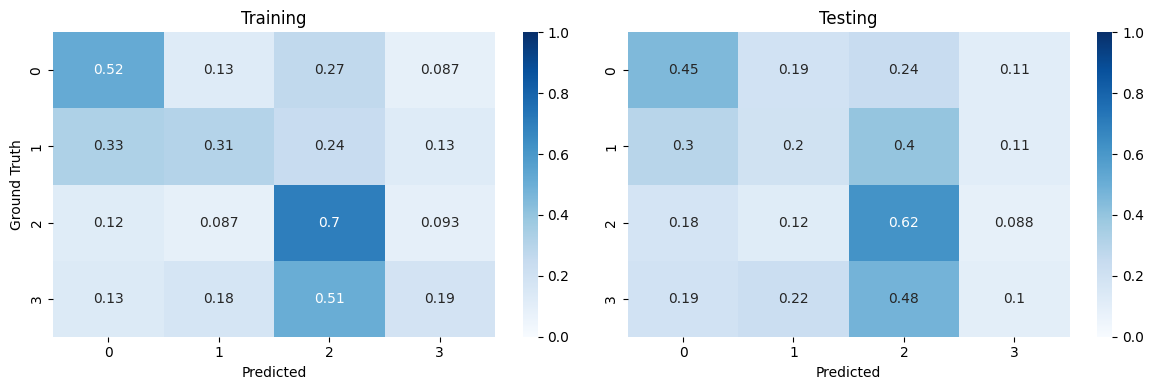

In [30]:
trM = metrics.confusion_matrix(Y_train, yp_train,normalize='true')
tsM = metrics.confusion_matrix(Y_test, yp_test,normalize='true')


plt.figure(figsize=(12,4))
plt.subplot(121)
sns.heatmap(trM, annot=True, cmap='Blues',vmin=0,vmax=1)
plt.xticks(np.arange(4)+0.5,Class_name)
plt.yticks(np.arange(4)+0.5,Class_name,rotation='vertical')
plt.title('Training')
plt.xlabel('Predicted')
plt.ylabel('Ground Truth')
plt.subplot(122)
sns.heatmap(tsM, annot=True, cmap='Blues',vmin=0,vmax=1)
plt.title('Testing')
plt.xticks(np.arange(4)+0.5,Class_name)
plt.yticks(np.arange(4)+0.5,Class_name,rotation='vertical')
plt.xlabel('Predicted')
#plt.ylabel('Ground Truth')
plt.tight_layout()
plt.show()

# SVM

In [31]:
MEAN = X_train_f.mean(0)
SD = X_train_f.std(0)

X_train_fn = (X_train_f - MEAN)/SD
X_test_fn = (X_test_f - MEAN)/SD

In [32]:
model = svm.SVC(kernel='rbf',C=1)

model.fit(X_train_fn, Y_train)


yp_train = model.predict(X_train_fn)
yp_test = model.predict(X_test_fn)


trAc = np.mean(yp_train==Y_train)
tsAc = np.mean(yp_test==Y_test)


print('Training Accuracy', trAc)
print('Testing  Accuracy', tsAc)

Training Accuracy 0.435933147632312
Testing  Accuracy 0.3129496402877698
